In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
varinfo.clear()

In [3]:
bkgtrees = ObjIter([Tree(filter(os.path.isfile,fc.eightb.preselection.Bkg_MC_List))])
# bkgtrees = ObjIter([])

In [4]:
signaltrees = ObjIter([ Tree(f) for f in fc.eightb.preselection.signal_list ])

In [5]:
for tree in signaltrees: tree.color=None

In [6]:
(bkgtrees+signaltrees).extend(kwargs=lambda t : build_collection(t,'H\dY\d_b\d','bjet',ptordered=True))

[None, None, None, None, None, None, None, None, None]

In [7]:
(bkgtrees+signaltrees).extend(kwargs=lambda t : build_collection(t,'H\dY\d','higgs',ptordered=True))

[None, None, None, None, None, None, None, None, None]

In [8]:
(bkgtrees+signaltrees).extend(kwargs=lambda t : build_collection(t,'Y\d','y',ptordered=True))

[None, None, None, None, None, None, None, None, None]

In [9]:
def calc_btag_vars(tree):
    bjet_btag = tree.bjet_btag.to_numpy()
    bjet_btag.sort()
    
    btagsum = bjet_btag.sum(axis=-1)/8.0
    btag_asym = bjet_btag.std(axis=-1)
    
    tree.extend(btagsum=btagsum, btag_asym=btag_asym)
    
(bkgtrees+signaltrees).apply(calc_btag_vars)


[None, None, None, None, None, None, None, None, None]

{'h_label': ['MC-Bkg', 'MX_700_MY_300', 'MX_900_MY_400', 'MX_1200_MY_500'], 'is_data': [False, False, False, False], 'is_signal': [False, True, True, True], 'density': 0, 'log': 0, 'ratio': 0, 'stacked': True, 'lumi': 2018, 'h_sumw2': True, 'h_label_stat': None, 'scale': [None, 100, 100, 100], 'legend': True, 'h_color': ['grey', None, None, None]}


(<Figure size 864x360 with 2 Axes>,
 array([<AxesSubplot:xlabel='btag_asym', ylabel='Events'>,
        <AxesSubplot:xlabel='btagsum', ylabel='Events'>], dtype=object))

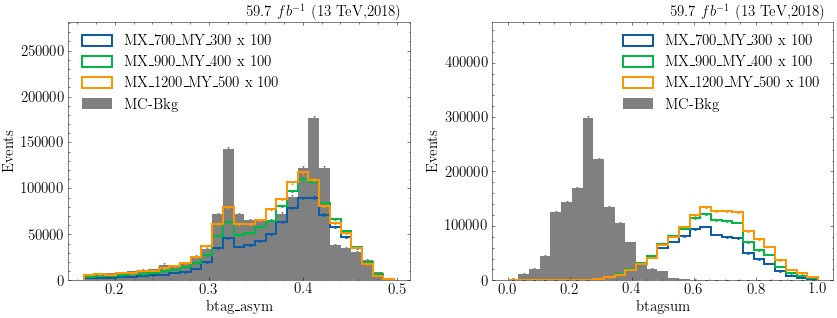

In [10]:
study.quick(   
    bkgtrees + signaltrees[[0,4,7]],
    varlist=['btag_asym','btagsum'],
    stacked=True,
    h_label_stat=None,
    scale=[None] + [100]*3,
    legend=True,
    binlist=[None,np.linspace(0,1,30)]
    # log=True,
    # cumulative=-1,
    # density=True,
    # s_xsec_scales=bkg_rhoscales,
    # dim=(-1,3),
)